# Messing around with spatial clustering in Mesa/python

We need our trees to have some sort of clustering coefficient, because some of my questions focus on deforestation and fragmentation. Let's try a Thomas process for generating clustering. This is adapted from Connor Johnson's [blog post](http://connor-johnson.com/2014/02/25/spatial-point-processes/) on point processes in python.

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

def PoissonPP( rt, Dx, Dy=None ):
    '''
    Determines the number of events `N` for a rectangular region,
    given the rate `rt` and the dimensions, `Dx`, `Dy`.
    Returns a <2xN> NumPy array.
    '''
    if Dy == None:
        Dy = Dx
    N = scipy.stats.poisson( rt*Dx*Dy ).rvs()
    x = scipy.stats.uniform.rvs(0,Dx,((N,1)))
    y = scipy.stats.uniform.rvs(0,Dy,((N,1)))
    P = np.hstack((x,y))
    return(P)

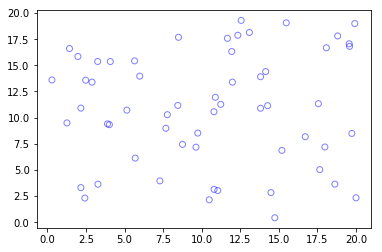

In [3]:
## try out, visualize
rate, Dx = 0.2, 20
P = PoissonPP( rate, Dx ).T
plt.scatter( P[0], P[1], edgecolor='b', facecolor='none', alpha=0.5 )
plt.show()

In [6]:
def ThomasPP( kappa, sigma, mu, Dx ):
    '''
    each forming a Poisson( mu ) numbered cluster of points,
    having an isotropic Gaussian distribution with variance `sigma`
    '''
    # create a set of parent points from a Poisson( kappa )
    # distribution on the square region [0,Dx] X [0,Dx]
    parents = PoissonPP( kappa, Dx )
    # M is the number of parents
    M = parents.shape[0]
    # an empty list for the Thomas process points
    TP = list()
    # for each parent point..
    for i in range( M ):
        # determine a number of children according
        # to a Poisson( mu ) distribution
        N = scipy.stats.poisson( mu ).rvs()
    # for each child point..
        for j in range( N ):
        # place a point centered on the location of the parent according
        # to an isotropic Gaussian distribution with sigma variance
                pdf = scipy.stats.norm( loc=parents[i,:2], scale=(sigma,sigma) )
                # add the child point to the list TP
                TP.append( list( pdf.rvs(2) ) )
    x,y = zip(*TP)
    pts = [x,y]
    return pts

In [12]:
aa = ThomasPP(kappa=3, sigma=0.2, mu=15, Dx=8)

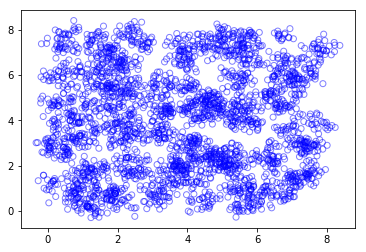

In [13]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )
plt.cshow()

In [14]:
aa = ThomasPP(kappa=3, sigma=0.1, mu=15, Dx=8)

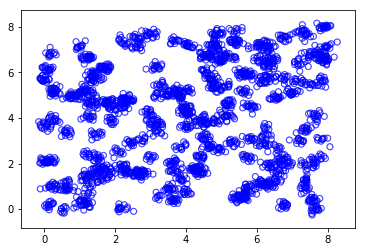

In [16]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )
plt.show()

In [17]:
aa = ThomasPP(kappa=3, sigma=0.2, mu=7, Dx=8)

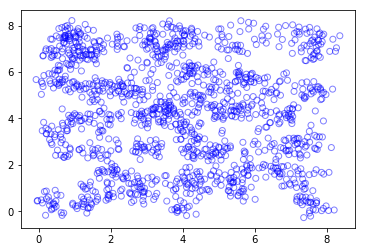

In [18]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )
plt.show()